In [52]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


In [53]:
import numpy as np
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Getting dataset from kaggle (Uncomment if you wish to check however we have kept local copy)

In [54]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("goubeast/age-prediction-av")
#print("Path to dataset files:", path)

In [55]:
#! ls data/train/old


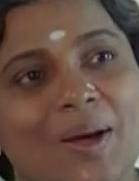

In [56]:
path = './data/train/old'
#name = '82.headshot.jpg'
name = '10019.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [57]:
img = load_img(fullname, target_size=(200, 200))
x = np.array(img)
x.shape

(200, 200, 3)

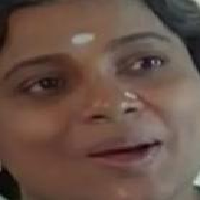

In [58]:
img

Model from scratch

In [59]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
model.compile(loss='binary_crossentropy',\
             optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8),\
             metrics=['acc'])

In [61]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_53 (Conv2D)              │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 313632)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │    20,072,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,073,473 (76.57 MB)

 Trainable params: 20,073,473 (76.57 MB)

 Non-trainable params: 0 (0.00 B)

Transfer learning: Reusing Imagenet model

In [62]:
from keras.applications.xception import Xception

In [63]:
# modify create model function
def create_model(learning_rate=0.001, size_inner=100):
  base_model = Xception(
      weights='imagenet',
      include_top=False,
      input_shape=(200, 200, 3)
  )
  base_model.trainable = False

  inputs = keras.Input(
      shape=(200,200,3)
  )

  base = base_model(inputs, training=False)

  vectors = keras.layers.GlobalAveragePooling2D()(base)

  # adding inner layer
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)

  # 2 classes
  outputs = keras.layers.Dense(2)(inner)

  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.SparseCategoricalCrossentropy(
      from_logits=True
  )

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
  )

  return model


In [64]:
train_dir = 'data/train'
test_dir = 'data/test'

#train_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [65]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 6830 images belonging to 2 classes.


In [66]:
train_generator.class_indices

{'old': 0, 'young': 1}

In [67]:
validation_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 2281 images belonging to 2 classes.


In [68]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 200, 200, 3)
labels batch shape: (20,)


In [69]:
model = create_model()

In [70]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)

Epoch 1/10


/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


342/342 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.8069 - loss: 0.4232 - val_accuracy: 0.8544 - val_loss: 0.3313
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8855 - loss: 0.2822 - val_accuracy: 0.8558 - val_loss: 0.3324
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8954 - loss: 0.2523 - val_accuracy: 0.8759 - val_loss: 0.2926
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9189 - loss: 0.2063 - val_accuracy: 0.8825 - val_loss: 0.2856
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9350 - loss: 0.1622 - val_accuracy: 0.8808 - val_loss: 0.3027
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9488 - loss: 0.1350 - val_accuracy: 0.8843 - val_loss: 0.3191
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9587 - loss: 0.1108 - val_accuracy: 0.8926 - val_loss: 0.2974
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9676 - loss: 0.0865 - val_accurac

Find the best learning rate for Adam optimizer

In [71]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = create_model(learning_rate=lr)
    history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    )
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.7699 - loss: 0.4681 - val_accuracy: 0.8233 - val_loss: 0.3890
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8502 - loss: 0.3494 - val_accuracy: 0.8571 - val_loss: 0.3279
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8789 - loss: 0.3034 - val_accuracy: 0.8628 - val_loss: 0.3161
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8867 - loss: 0.2802 - val_accuracy: 0.8742 - val_loss: 0.3012
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9057 - loss: 0.2505 - val_accuracy: 0.8663 - val_loss: 0.3173
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9063 - loss: 0.2355 - val_accuracy: 0.8816 - val_loss: 0.2862
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9139 - loss: 0.2252 - val_accuracy: 0.8851 - val_loss: 0.2791
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9252 - loss: 0.

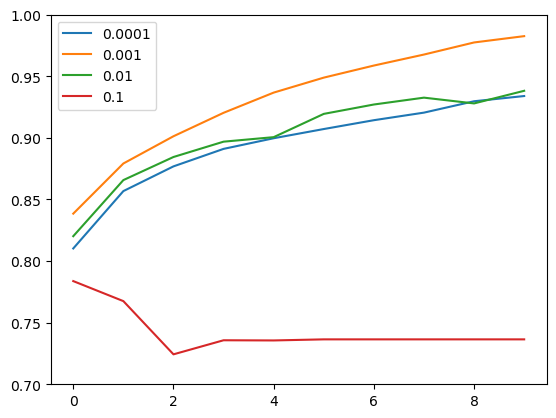

In [72]:
for lr, hist in scores.items():
  plt.plot(
      hist['accuracy'],
      label=lr
  )

plt.ylim(0.70, 1)
plt.legend()

In [73]:
# Best learning rate
learning_rate = 0.001

Find the best size for inner layer

In [74]:
scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = create_model(learning_rate, size_inner=size)
    history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    )
    scores[size] = history.history

    print()
    print()

10
Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step - accuracy: 0.7912 - loss: 0.4434 - val_accuracy: 0.8593 - val_loss: 0.3273
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8624 - loss: 0.3259 - val_accuracy: 0.8663 - val_loss: 0.3122
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8857 - loss: 0.2669 - val_accuracy: 0.8654 - val_loss: 0.3218
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8948 - loss: 0.2562 - val_accuracy: 0.8803 - val_loss: 0.2891
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9157 - loss: 0.2216 - val_accuracy: 0.8777 - val_loss: 0.2977
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9209 - loss: 0.2008 - val_accuracy: 0.8838 - val_loss: 0.2794
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9296 - loss: 0.1806 - val_accuracy: 0.8466 - val_loss: 0.3595
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9320 - loss: 0.1795

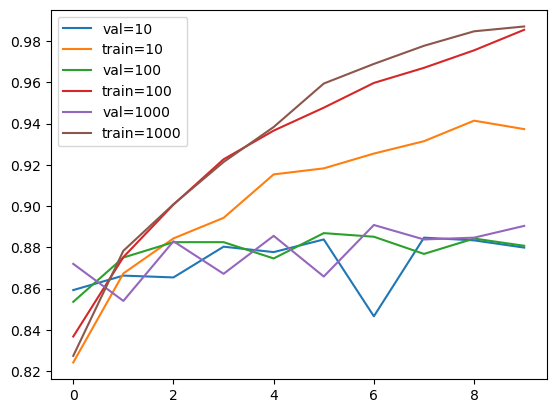

In [75]:
for size, hist in scores.items():
  plt.plot(
      hist['val_accuracy'],
      label=('val=%s' % size),
  )
  plt.plot(
      hist['accuracy'],
      label=('train=%s' % size)
  )

  plt.legend()

In [76]:
# Best size
size_inner = 100

Dropout and regularization

In [77]:
def create_model(learning_rate=0.001, size_inner=100, drop_rate=0.5):
  base_model = Xception(
      weights='imagenet',
      include_top=False,
      input_shape=(200, 200, 3)
  )
  base_model.trainable = False

  inputs = keras.Input(
      shape=(200,200,3)
  )

  base = base_model(inputs, training=False)

  vectors = keras.layers.GlobalAveragePooling2D()(base)

  # adding inner layer
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)

  # dropout
  drop = keras.layers.Dropout(drop_rate)(inner)

  # 2 classes
  outputs = keras.layers.Dense(2)(drop)

  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.SparseCategoricalCrossentropy(
      from_logits=True
  )

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
  )

  return model

Find the best drop out rate

In [78]:
scores = {}

for drop_rate in [0.0, 0.2, 0.5, 0.8]:
    print(drop_rate)

    model = create_model(drop_rate = drop_rate)
    history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    )
    scores[drop_rate] = history.history

    print()
    print()

0.0
Epoch 1/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - accuracy: 0.8118 - loss: 0.4164 - val_accuracy: 0.8531 - val_loss: 0.3334
Epoch 2/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8695 - loss: 0.3041 - val_accuracy: 0.8615 - val_loss: 0.3374
Epoch 3/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9042 - loss: 0.2358 - val_accuracy: 0.8886 - val_loss: 0.2754
Epoch 4/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9244 - loss: 0.1966 - val_accuracy: 0.8922 - val_loss: 0.2646
Epoch 5/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9385 - loss: 0.1594 - val_accuracy: 0.8768 - val_loss: 0.2921
Epoch 6/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9465 - loss: 0.1361 - val_accuracy: 0.8913 - val_loss: 0.2868
Epoch 7/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9637 - loss: 0.0975 - val_accuracy: 0.8772 - val_loss: 0.3364
Epoch 8/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9739 - loss: 0.073

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9924 - loss: 0.0243 - val_accuracy: 0.8869 - val_loss: 0.5044
Epoch 28/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9907 - loss: 0.0252 - val_accuracy: 0.8904 - val_loss: 0.4906
Epoch 29/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9923 - loss: 0.0257 - val_accuracy: 0.8865 - val_loss: 0.6038
Epoch 30/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.9918 - loss: 0.0212 - val_accuracy: 0.8873 - val_loss: 0.5092


0.5
Epoch 1/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.7868 - loss: 0.4787 - val_accuracy: 0.8531 - val_loss: 0.3417
Epoch 2/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8490 - loss: 0.3537 - val_accuracy: 0.8707 - val_loss: 0.3094
Epoch 3/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8679 - loss: 0.3142 - val_accuracy: 0.8702 - val_loss: 0.3034
Epoch 4/30
342/342 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8771 - loss: 0.2911 - va

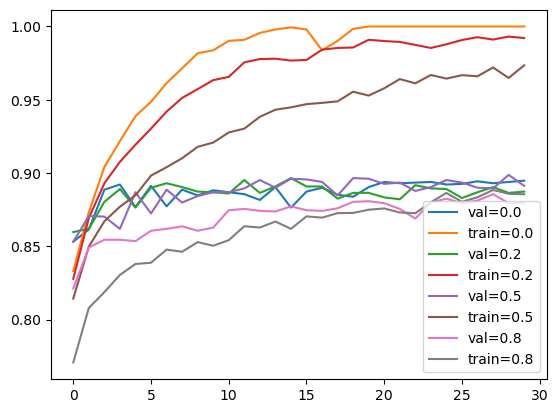

In [79]:
for drop, hist in scores.items():
  plt.plot(
      hist['val_accuracy'],
      label=('val=%s' % drop),
  )
  plt.plot(
      hist['accuracy'],
      label=('train=%s' % drop)
  )

plt.legend()

In [80]:
drop_rate = 0.2

Data Augmentation

In [81]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [82]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [83]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 6830 images belonging to 2 classes.


In [84]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 2281 images belonging to 2 classes.


Create Checkpoint

In [85]:
# Create checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'#max monitor variable
)

Use model with best values for Learning rate, Inner size and Drop out rate

In [86]:
model = create_model(drop_rate = drop_rate)
# Optimal values for learning rate (0.001) and Inner size (100) are already default values. 

In [87]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step - accuracy: 0.7587 - loss: 0.4918 - val_accuracy: 0.8224 - val_loss: 0.3926
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 59s 174ms/step - accuracy: 0.8198 - loss: 0.4129 - val_accuracy: 0.8303 - val_loss: 0.3684
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 59s 174ms/step - accuracy: 0.8336 - loss: 0.3833 - val_accuracy: 0.8439 - val_loss: 0.3502
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 59s 172ms/step - accuracy: 0.8334 - loss: 0.3813 - val_accuracy: 0.8413 - val_loss: 0.3517
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 59s 174ms/step - accuracy: 0.8455 - loss: 0.3465 - val_accuracy: 0.8457 - val_loss: 0.3508
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 59s 172ms/step - accuracy: 0.8423 - loss: 0.3583 - val_accuracy: 0.8343 - val_loss: 0.3707
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 59s 173ms/step - accuracy: 0.8474 - loss: 0.3430 - val_accuracy: 0.8531 - val_loss: 0.3420
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 59s 172ms/step - accuracy: 0.8454 - loss: 0

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



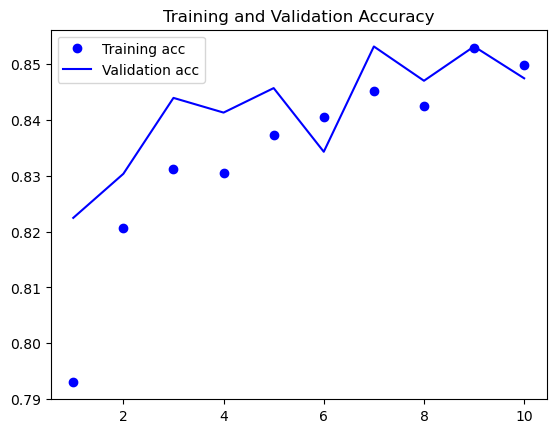

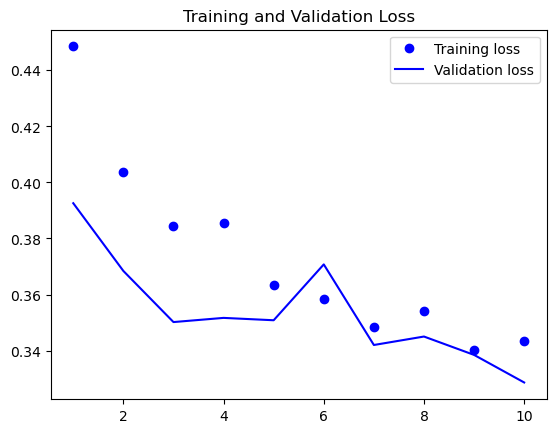

In [88]:
acc_aug = history.history['accuracy']
val_acc_aug = history.history['val_accuracy']
loss_aug = history.history['loss']
val_loss_aug = history.history['val_loss']

epochs_aug = range(1, len(acc_aug) + 1)

plt.plot(epochs_aug, acc_aug, 'bo', label='Training acc')
plt.plot(epochs_aug, val_acc_aug, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_aug, loss_aug, 'bo', label='Training loss')
plt.plot(epochs_aug, val_loss_aug, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [89]:
loss_mean_aug = np.mean(val_loss_aug)
loss_mean_aug

np.float64(0.3538417875766754)

In [90]:
val_acc_aug[5:10]

[0.8342832326889038,
 0.8531345725059509,
 0.8469969034194946,
 0.8531345725059509,
 0.8474353551864624]

In [91]:
acc_mean_aug = np.mean(val_acc_aug[5:10])
acc_mean_aug

np.float64(0.8469969272613526)

Using a saved model via checkpoint

In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

In [93]:
model = keras.models.load_model('xception_v1_08_0.893.keras')

In [94]:
model.evaluate(validation_generator)

115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8868 - loss: 0.5355


[0.5033976435661316, 0.8925909399986267]

In [95]:
path = 'data/test/young/10056.jpg'
img = load_img(path, target_size=(200, 200))

In [96]:
import numpy as np
x = np.array(img)
X = np.array([x])
X.shape

(1, 200, 200, 3)

In [97]:
X = preprocess_input(X)
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [98]:
pred[0]

array([-1.584364 ,  1.1029187], dtype=float32)

In [99]:
import tensorflow as tf

probabilities = tf.nn.softmax(pred[0]).numpy()
print(probabilities)

[0.06372795 0.936272  ]


Convert model to TF-Lite

In [100]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpzgvtlrv0/assets


INFO:tensorflow:Assets written to: /tmp/tmpzgvtlrv0/assets


Saved artifact at '/tmp/tmpzgvtlrv0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='input_layer_10')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139711659390160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139711659391696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139711659391888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139711659391504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139711659391120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139711659389776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139711110758480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139711110759248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139711659392656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139711659392272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139711110759

W0000 00:00:1738500468.648701     762 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1738500468.648731     762 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-02 12:47:48.648947: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpzgvtlrv0
2025-02-02 12:47:48.662299: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-02 12:47:48.662322: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpzgvtlrv0
2025-02-02 12:47:48.805531: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-02 12:47:49.711268: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpzgvtlrv0
2025-02-02 12:47:49.910362: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 1261417 microseconds.
